# xpopy
This is an unofficial implementation for the paper below. The acceleration is mainly owing to the **ufuncs** in [PyGEOS](https://github.com/pygeos/pygeos) and [NumPy](https://github.com/numpy/numpy), which tries to avoid iteration to provide a better performance (~**10** times the speed over [the official one](https://github.com/Kang-Sun-CfA/Oversampling_matlab/blob/master/popy.py) under a two-core benchmark). In addition, the geometry operation seems to be more intuitive and easier to understand in the code snippets.  

> Sun, K., Zhu, L., Cady-Pereira, K., Chan Miller, C., Chance, K., Clarisse, L., Coheur, P.-F., González Abad, G., Huang, G., Liu, X., Van Damme, M., Yang, K., and Zondlo, M.: A physics-based approach to oversample multi-satellite, multispecies observations to a common grid, Atmos. Meas. Tech., 11, 6679–6701, https://doi.org/10.5194/amt-11-6679-2018, 2018.


## Data preparation
Currently only tested on TROPOMI no2 data, so we pull the tropomi NO2 products from AWS.

In [4]:
!pip install awscli

In [2]:
!aws s3 sync s3://meeo-s5p/OFFL/L2__NO2___/2022/07/24/TROPOMI --no-sign-request
!cp TROPOMI/S5P_OFFL_L2__NO2____20220724T0356*.nc ./

usage: 
Note: AWS CLI version 2, the latest major version of the AWS CLI, is now stable and recommended for general use. For more information, see the AWS CLI version 2 installation instructions at: https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2.html

usage: aws [options] <command> <subcommand> [<subcommand> ...] [parameters]
To see help text, you can run:

  aws help
  aws <command> help
  aws <command> <subcommand> help
aws.cmd: error: the following arguments are required: paths
'cp' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


## Original popy implementation
forked from https://github.com/Kang-Sun-CfA/Oversampling_matlab/

In [4]:
!git clone https://github.com/HeQinWill/xpopy
!cp xpopy/popy.py ./

'git' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
'cp' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [1]:
import popy
l2_obj = popy.popy(
        instrum='TROPOMI',
        product='NO2',
        grid_size=0.05,
        west=110,
        east=136,
        south=10,
        north=50,
        start_year=2022,
        start_month=7,
        start_day=24,
        start_hour=0,
        start_minute=0,
        start_second=0,
        end_year=2022,
        end_month=7,
        end_day=24,
        end_hour=5,
        end_minute=22,
        end_second=59,
        verbose=True,
)

l2_obj.min_qa_value = 0.75
l2_obj.F_subset_S5PNO2(path ='/content',
                s5p_product='OFFL',
                data_fields=[],
                data_fields_l2g=[])

print(l2_obj.pixel_shape)
l2_obj.l2_list

E:\xpopy-master\popy.py:305: SyntaxWarning: invalid escape sequence '\d'
  pattern recognizable by re in python, usually r'\d{8}T\d{6}' <=> '%Y%m%dT%H%M%S'
E:\xpopy-master\popy.py:3887: SyntaxWarning: invalid escape sequence '\S'
  l2_path_pattern=r'C:\research\S5PSO2\L2\S5P*L2__SO2____%Y%m%dT*.nc'
please use l2_list or l2_path_pattern instead
E:\xpopy-master\popy.py:305: SyntaxWarning: invalid escape sequence '\d'
  pattern recognizable by re in python, usually r'\d{8}T\d{6}' <=> '%Y%m%dT%H%M%S'
E:\xpopy-master\popy.py:3887: SyntaxWarning: invalid escape sequence '\S'
  l2_path_pattern=r'C:\research\S5PSO2\L2\S5P*L2__SO2____%Y%m%dT*.nc'


FileNotFoundError: [WinError 2] 系统找不到指定的文件。: '/content'

In [5]:
%%time
l3 = l2_obj.F_parallel_regrid(ncores=2)

CPU times: user 801 ms, sys: 197 ms, total: 998 ms
Wall time: 1min 10s


## Compact xpopy implementation

In [5]:
!pip install pygeos

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [28 lines of output]
      <string>:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
      C:\Users\24053\AppData\Local\Temp\pip-install-ykakituw\pygeos_ec63e7527b8e4094874a1854605aba42\versioneer.py:564: SyntaxWarning: invalid escape sequence '\s'
        mo = re.search(r'=\s*"(.*)"', line)
      Could not find geos-config executable. Either append the path to geos-config to PATH or manually provide the include_dirs, library_dirs, libraries and other link args for compiling against a GEOS version >=3.5.
      Compiling pygeos/_geometry.pyx because it changed.
      Compiling pygeos/_geos.pyx because it changed.
      [1/2] Cythonizing pygeos/_geometry.pyx
      [2/

In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import pygeos
from pygeos import polygons, linestrings, points
from pygeos.measurement import area, distance, length
import cv2

In [8]:
%%time
# copy values from popy l2_obj
# TODO: read the original data directly
l2g_data = l2_obj.l2g_data

nl2 = len(l2g_data['latc'])
latc = l2g_data['latc'].data
lonc = l2g_data['lonc'].data
latr = l2g_data['latr'].data
lonr = l2g_data['lonr'].data

west = l2_obj.west
east = l2_obj.east
south = l2_obj.south 
north = l2_obj.north
grid_size = l2_obj.grid_size

ce_l3 = np.tile((l2_obj.xmesh, l2_obj.ymesh),1).reshape(2,-1).T

# construct l2 swath geometry polygons
l2 = polygons(np.stack((lonr,latr), axis=-1))

# calculate the area of each polygon
area_weight = area(l2)

# construct l2 swath corner points
lb = points(np.stack((lonr[:,0],latr[:,0]), axis=-1))
lt = points(np.stack((lonr[:,1],latr[:,1]), axis=-1))
rt = points(np.stack((lonr[:,2],latr[:,2]), axis=-1))
rb = points(np.stack((lonr[:,3],latr[:,3]), axis=-1))

# calculate the length and set the fwhm
# 0.25 = 0.5 (Half) × 0.5 (the average length of two sides)
fwhmx = (distance(lt, rt)+distance(lb, rb))*0.25
fwhmy = (distance(lt, lb)+distance(rt, rb))*0.25

# equation 6&7
k1 = 4
k2 = 2
k3 = 1
wx = fwhmx/(np.log(2)**(1/k1/k3))
wy = fwhmy/(np.log(2)**(1/k2/k3))

# construt the transformed coordinates using fwhm
dst = [[-fwhmx,-fwhmy],[-fwhmx,fwhmy],[fwhmx,fwhmy],[fwhmx,-fwhmy]]
dst = np.array(dst, dtype='float32')  # (4, 2, nl2)

# calculate the difference between the 4 corners and the center point
# set the center point to the coordinate origin
lond = lonr - lonc.reshape(-1,1)
latd = latr - latc.reshape(-1,1)
src = np.stack((lond, latd), axis=-1)
src = np.array(src, dtype='float32')  # (nl2, 4, 2)

# derive the perspective transform parameters
tform = [cv2.getPerspectiveTransform(src[i], dst[:,:,i]) for i in range(nl2)]
tform = np.array(tform)

# construct R-tree of l3 center points
l3_tree = pygeos.STRtree(points(ce_l3), leafsize=128)

# set l2 buffer
# 1. no buffer
# l2_buffer = l2
# 2. simple buffer (uniform with the half of max{fwhmx,fwhmy} of each polygon)
margin = fwhmx.copy()
margin[fwhmy>fwhmx] = fwhmy[fwhmy>fwhmx]
l2_buffer = pygeos.buffer(l2, margin/2)
# 3. polygon with a margin (consistent with source code)
# TODO
"""
# Maybe judging whether the l2 polygon is overlapped with the l3 grid is enough
l3_geo = polygons(np.stack((lb_l3,lt_l3,rt_l3,rb_l3), axis=1))
l3_tree = pygeos.STRtree(l3_geo, leafsize=128)
t = l3_tree.query_bulk(l2, predicate='overlaps')
"""

# find all situation where l2 buffer polygons contains the l3 center points
# t[0]: the 1st dimesion is l2 object index
# t[1]: the 2nd dimesion is l3 object index
t = l3_tree.query_bulk(l2_buffer, predicate='contains')

# calculate the difference between the l3 center and the corresponding l2 center
xym1 = ce_l3[t[1]] - np.stack((lonc[t[0]], latc[t[0]]),axis=-1)

# apply the perspective transform parametes
# only the first 6 parameters (2 lines) need to be used
a = tform[t[0], :2]  # (T, 2, 3)
b = np.column_stack((xym1, np.ones(len(xym1)) ))[:,:,np.newaxis]  # (T, 2+1, 1)
xym2 = np.matmul(a,b).squeeze()  # (T, 2, 1) -> (T, 2)

# equation 5
x_term = -np.abs(xym2[:,0]/wx[t[0]])**k1
y_term = -np.abs(xym2[:,1]/wy[t[0]])**k2

# record with a table for subsequent processing
df = pd.DataFrame()
df['lon'] = ce_l3[t[1], 0]
df['lat'] = ce_l3[t[1], 1]
df['sg'] = np.exp(x_term+y_term)
df['area_weight'] = area_weight[t[0]]
df['uncertainty_weight'] = l2g_data['column_uncertainty'].data[t[0]]
df['tmp_wt'] = df['sg']/df['area_weight']/df['uncertainty_weight']
for ivar in ['column_amount', 'albedo', 'surface_altitude']:
    df[f'sum_aboves_{ivar}'] = df['tmp_wt'] * l2g_data[ivar].data[t[0]]

# sum the values of each grid at the same location
# then merge it with an empty table of full grids
df_ = pd.DataFrame(ce_l3, columns=['lon', 'lat'])
df_.set_index(['lat', 'lon'], inplace=True)
df_ = df_.merge(df.groupby(['lat', 'lon']).sum(),
                how='left', left_index=True, right_index=True)

# rename the column name and set the quality flag
df_ = df_.rename(columns={'sg':'num_samples', 'tmp_wt':'total_sample_weight'})
df_['quality_flag'] = 2
df_.loc[df_.num_samples >= 0.1, 'quality_flag'] = 1
df_.loc[(df_.num_samples > 1.e-6)&(df_.num_samples < 0.1), 'quality_flag'] = 0

# convert the table to an xarray dataset
ds = df_.to_xarray()
ds['lat'].attrs = {'units': 'degree_north'}
ds['lon'].attrs = {'units': 'degree_east'}
for ivar in ['column_amount', 'albedo', 'surface_altitude']:
    ds[ivar] = ds[f'sum_aboves_{ivar}']/ds['total_sample_weight']

CPU times: user 6.05 s, sys: 772 ms, total: 6.82 s
Wall time: 6.83 s


## Comparison

In [9]:
ds['column_amount_from_popy'] = ds['column_amount'].copy()
ds['column_amount_from_popy'][:] = l3['column_amount']

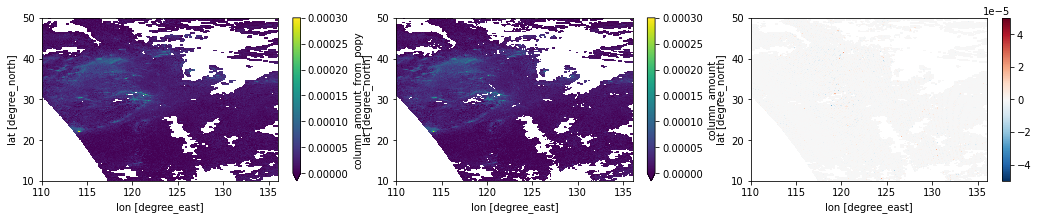

In [10]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,3))
ds['column_amount_from_popy'].plot(ax=ax1, vmin=0, vmax=0.0003)
ds['column_amount'].plot(ax=ax2, vmin=0, vmax=0.0003)
(ds['column_amount_from_popy'] - ds['column_amount']).plot(ax=ax3, vmin=-5e-5)